In [ ]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

   Run Number  BO Iter  Best Error  Exploration Bias       Opt Acq  \
0           4        1  559.013745               1.0  5.129206e+02   
1           4        2   46.248958               1.0  3.183231e-12   
2           4        3   46.248958               1.0  3.183231e-12   
3           4        4   46.248958               1.0  1.412525e-11   
4           4        5   46.248958               1.0  3.183231e-12   

                                       Theta Opt Acq    Min Obj  Min Obj Act  \
0  [0.6497615481427451, -2.175199234073253, 0.802...  46.249456    46.249456   
1  [-4.323431269157526, 4.8917995719376846, 0.652...  23.268154    23.268154   
2  [-4.323431269157526, 4.891799561937685, 0.6529...   0.007446     0.007446   
3  [-3.470149890727296, -0.3930094038255447, 0.92...   0.005748     0.005748   
4  [-4.323431269157526, 4.891799561937685, 0.6529...  92.854288    92.854288   

                                       Theta Min Obj Min Obj Cum.  ...  \
0  [0.649761361721735, -

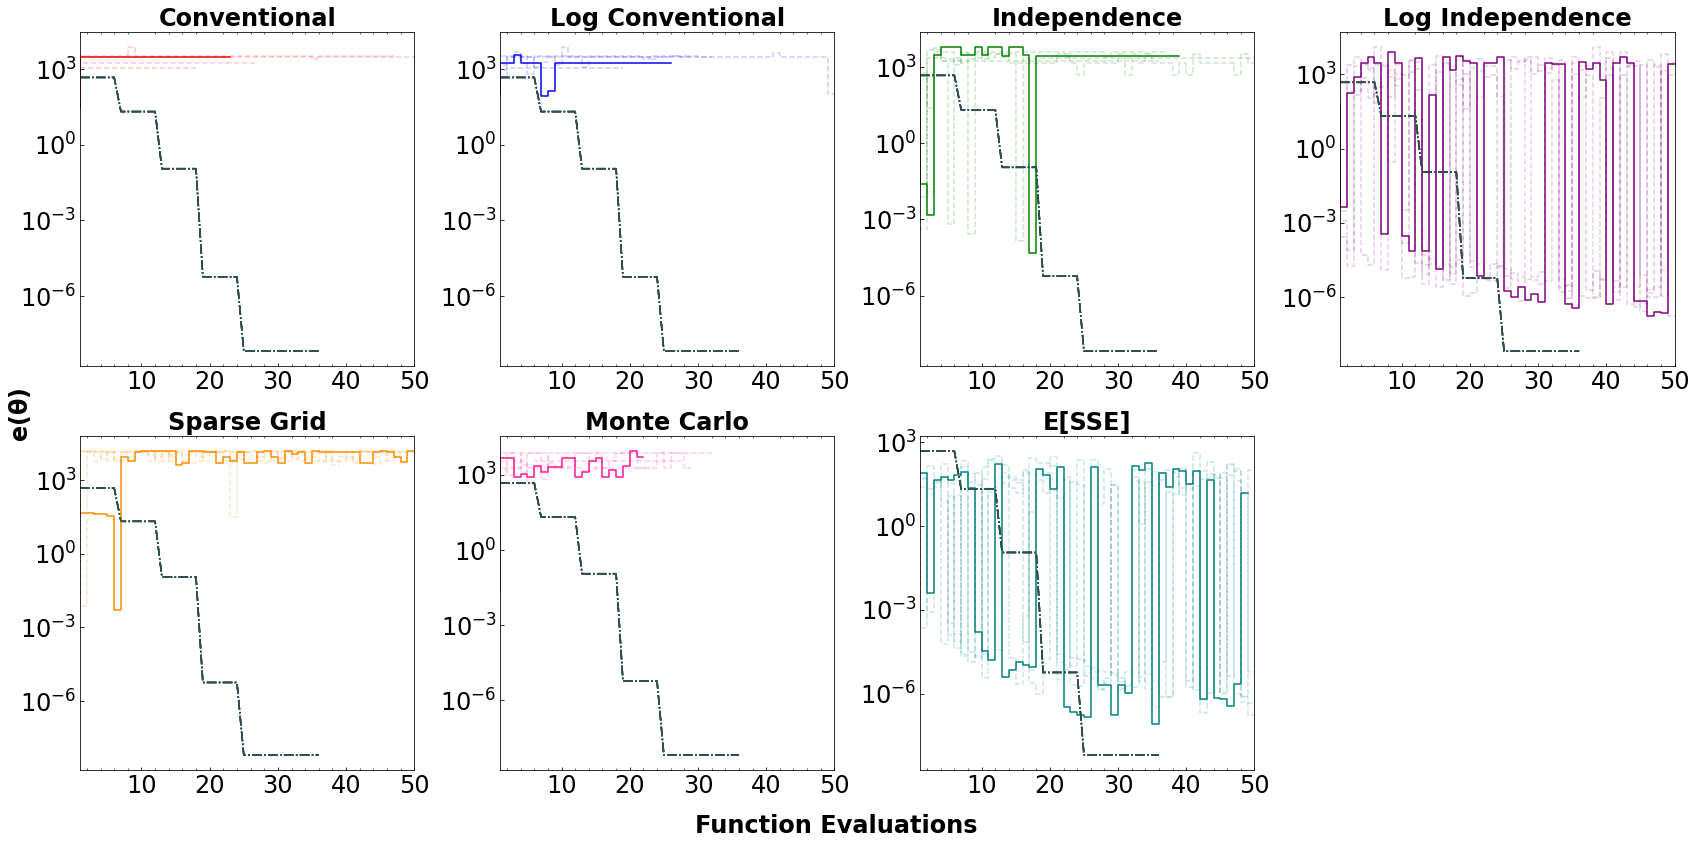

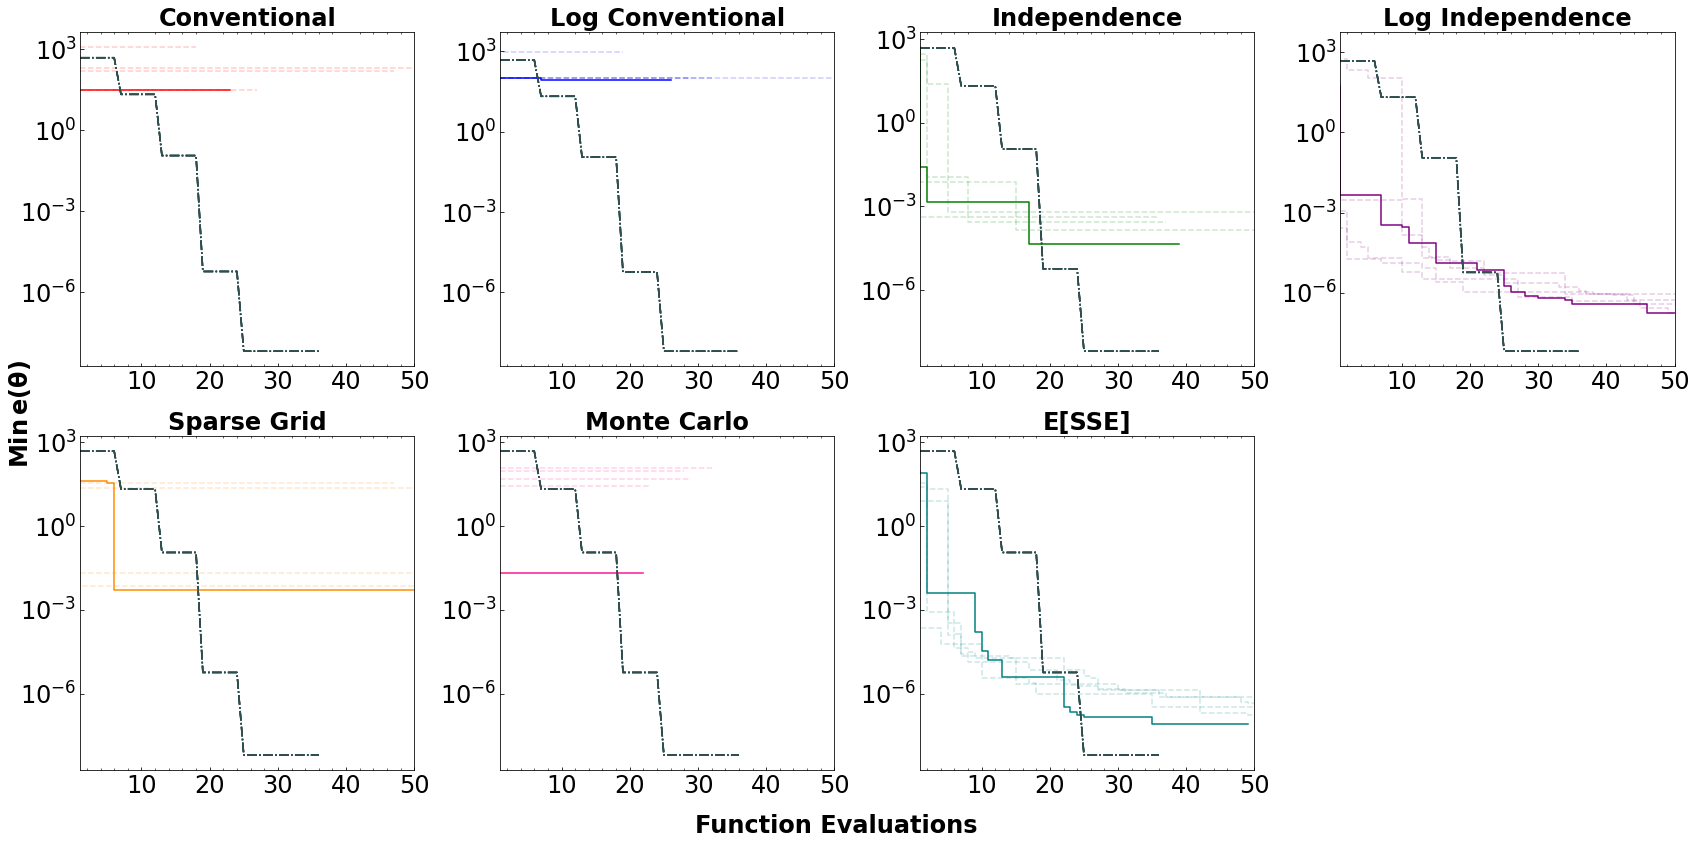

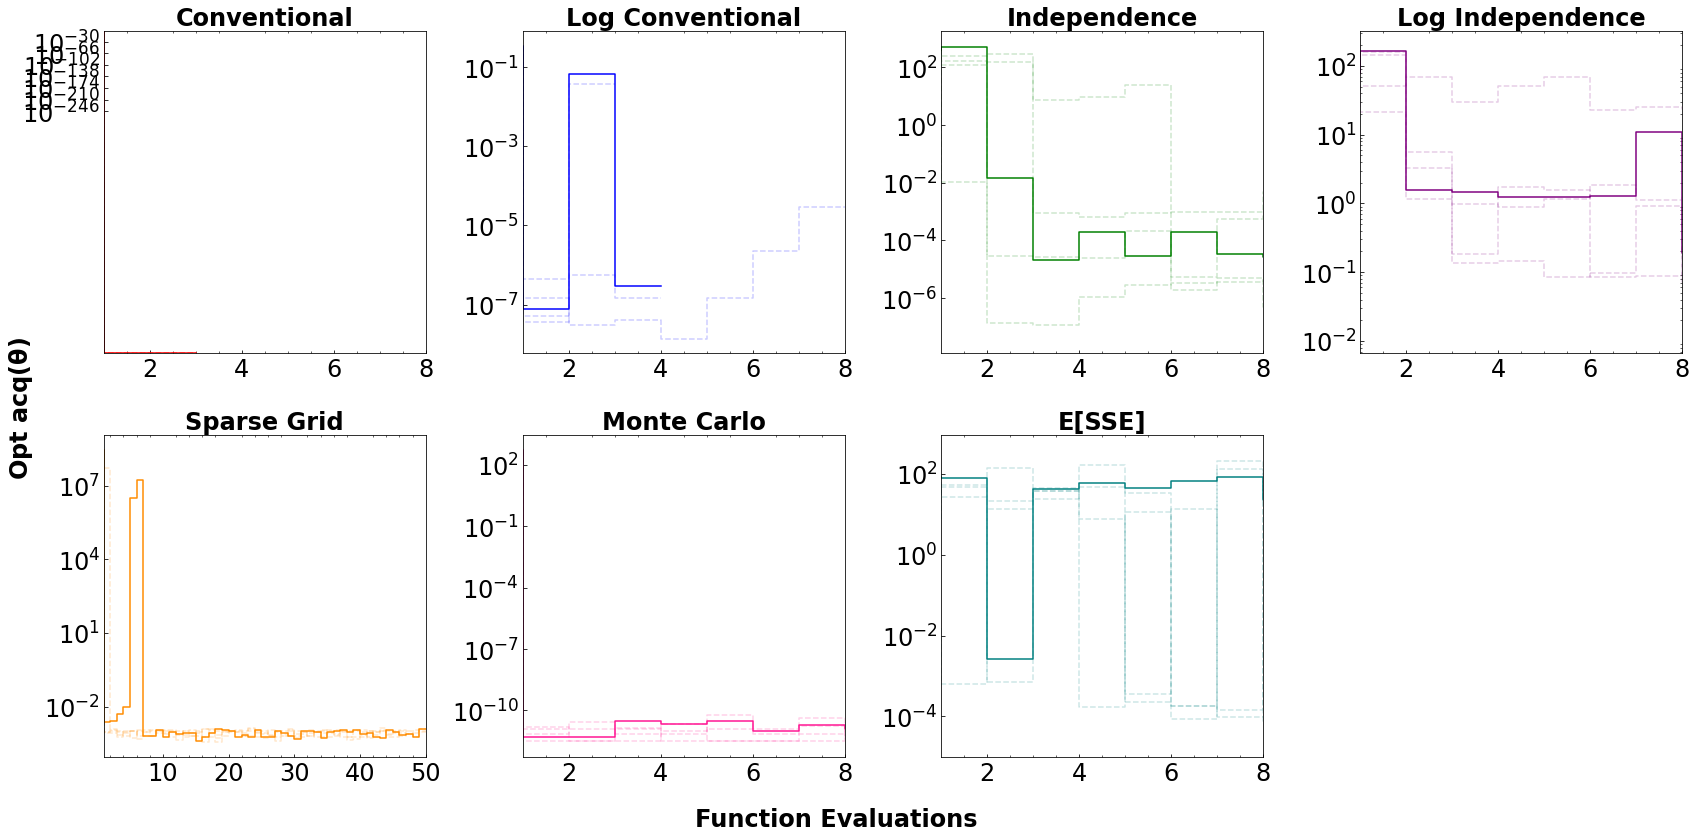

In [5]:
import numpy as np
import pandas as pd
import signac
import os
from itertools import combinations
import signac

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.analyze_data import General_Analysis
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import Plotters

#Ignore warnings
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

#Set Stuff
meth_name_val_list = [1, 2, 3, 4, 5, 6, 7]
save_csv = True #Set to False if you don't want to save/resave csvs
save_figs = False #Set to False if you don't want to save/resave figs
project = signac.get_project()

for val in [11]:
    criteria_dict = {"cs_name_val" : val,
                    "ep_enum_val": 1,
                    "gp_package":"gpflow",
                    "meth_name_val": {"$in": meth_name_val_list}}

    analyzer = General_Analysis(criteria_dict, project, save_csv)
    plotters = Plotters(analyzer, save_figs)

    ###Get all data from experiments
    df_all_jobs, job_list, theta_true_data = analyzer.get_df_all_jobs(save_csv)
    print(df_all_jobs.head())
    print(df_all_jobs.columns)
    ## Get Best Data from ep experiment
    df_best, job_list_best = analyzer.get_best_data()
    print(df_best)
    # #Loop over z_choices to make comparison line plots
    z_choices = ["sse", "min_sse", "acq"]
    titles = ["Min SSE Parameter Values", "Min SSE Parameter Values Overall", "Optimal Acq Func Parameter Values"]

    #Get plot with each method on a different subplot for each obj
    for i in range(len(z_choices)):
        plotters.plot_one_obj_all_methods(z_choices[i])    

In [ ]:
# print(df_all_jobs[["BO Method","Opt Acq Min Obj Cum", "Min Obj Cum."]])
# print(df_all_jobs["BO Method"].unique())
# # Compare the two rows
# comparison = df_all_jobs["Opt Acq Min Obj Cum"] < df_all_jobs["Min Obj Cum."]
# # Count the number of True values
# count_smaller = comparison.sum()
# print(count_smaller)

df_best

In [ ]:
#From signac
import signac
meth_name_val_list = [1, 2, 3, 4, 5, 6, 7]

criteria_dict = {"cs_name_val" : 1,
                 "ep_enum_val": {"$gte": 1},
                 "meth_name_val": {"$in": meth_name_val_list}}

criteria_dict = {"cs_name_val" : 1,
                 "ep_enum_val": 1,
                 "meth_name_val": {"$in": meth_name_val_list}}

criteria_dict = {"cs_name_val" : 1,
                 "gp_package":"gpflow",
                 "meth_name_val": {"$in": [1,2,3,4,5,6,7]}}
# "param_name_str":{"$exists": False}
project = signac.get_project()
save_csv = False
save_figs = False
analyzer = General_Analysis(criteria_dict, project, save_csv)
plotters = Plotters(analyzer, save_figs)

In [ ]:
# df_all_jobs, job_list, theta_true = analyzer.get_df_all_jobs(save_csv)
df_best, job_list_best = analyzer.get_best_data()

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)
    
df_best

In [ ]:
plotters.plot_thetas(job_list_best[0], "min_sse", title = None)

In [ ]:
print(df_best["Theta Min Obj"].values)

In [ ]:
plotters.plot_one_obj_all_methods("acq")

In [ ]:
plotters.make_parity_plots()

In [ ]:
tot_runs = 1000
ls_analyzer = LS_Analysis(criteria_dict, project, save_csv)
ls_analyzer.num_x = 5
local_mins = ls_analyzer.categ_min(tot_runs)
local_mins

In [ ]:
print(local_mins["Theta Min Obj Cum."].values)

In [ ]:
ls_analyzer = LS_Analysis(criteria_dict, project, save_csv)
ls_results = ls_analyzer.least_squares_analysis()
ls_results_sort = ls_results.sort_values(by=['Min Obj Cum.', 'Iter'], ascending=True)
ls_runs = ls_results_sort.drop_duplicates(subset="Run", keep='first')
ls_runs
# ls_results
# ls_results[ls_results["Run"] == 1]

In [ ]:
plotters.plot_hypers(job_list_best[1], title = None)

In [ ]:
plotters.plot_objs_all_methods(["min_sse", "sse", "acq"])

In [ ]:
# title = "Heat Map Pair " + z_choice
levels = [100, 100, 100, 100, 100, 100, 100]
pair = 0
z_choice = "sse_mean"
plotters.plot_hms_all_methods(pair, z_choice, levels, log_data = False, title = None)

In [ ]:
levels = [100, 100, 100, 100]
pair = 0
z_choice = ["sse_sim", "sse_mean", "sse_var", "acq"]
plotters.plot_hms_gp_compare(job_list_best[0], df_best["Run Number"].iloc[0], df_best["BO Iter"].iloc[0], 
                             pair, z_choice, levels, log_data = False, title = None)

In [ ]:
#Make Heat maps for all pairs
z_choices = ["sse_sim", "sse_mean", "sse_var", "acq"]
levels = [100,100,100,100]

#Loop over best jobs
for i in range(len(job_list_best)):   
    #Get jobs, runs, and iters to examine
    job = job_list_best[i]
    run_num = df_best["Run Number"].iloc[i]
    bo_iter = df_best["BO Iter"].iloc[i]
    
    #Back out number of parameters
    string_val = df_best["Theta Min Obj"].iloc[0]
    try:
        numbers = [float(num) for num in string_val.replace('[', '').replace(']', '').split()]
    except:
        numbers = [float(num) for num in string_val]
        
    #Create list of parameter pair combinations
    dim_theta = len(np.array(numbers).reshape(-1, 1))
    dim_list = np.linspace(0, dim_theta-1, dim_theta)
    pairs = len((list(combinations(dim_list, 2))))
    
    #Loop over parameter pairs
    for pair in range(pairs):
        plotters.plot_hms_gp_compare(job, run_num, bo_iter, pair, z_choices, levels)